<a href="https://colab.research.google.com/github/JuanMorales765/Amigo-secreto/blob/main/revmodreglogv_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalacion, Importacion y Carga de Datos

In [1]:
!pip install ucimlrepo


In [2]:
!pip install ucimlrepo imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

In [3]:
iranian_churn = fetch_ucirepo(id=563)
x = iranian_churn.data.features
y = iranian_churn.data.targets
dfEsp = pd.concat([x, y], axis=1)

## Elección de Variables FINAL (Eliminamos las de VIF alto como Valor_cliente)
# Esto garantiza que el modelo sea estable

In [4]:
# Define the renaming dictionary based on the actual dfEsp columns from ucimlrepo
rename_cols = {
    'Call  Failure': 'Fallos_Llamadas',
    'Complains': 'Quejas',
    'Subscription  Length': 'Meses_permanencia',
    'Charge  Amount': 'Cargo',
    'Seconds of Use': 'Total_segundos',
    'Frequency of use': 'Total_llamadas',
    'Frequency of SMS': 'Total_mensajes',
    'Distinct Called Numbers': 'Llamadas_numeros_distintos',
    'Age Group': 'Grupo_edades',
    'Tariff Plan': 'Plan_tarifa',
    'Status': 'Estado_clientes',
    'Age': 'Edad',
    'Customer Value': 'Valor_cliente',
    'Churn': 'Abandono'
}

# Apply the renaming to dfEsp
dfEsp = dfEsp.rename(columns=rename_cols)

columnas_finales = ['Quejas', 'Total_llamadas', 'Cargo']
x = dfEsp[columnas_finales]
y = dfEsp['Abandono'] # Use 'Abandono' after renaming

## División de datos

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Entrenamiento con Pipeline y GridSearch
Aquí implementamos la Regresión Logística con el RobustScaler (necesario para logística) y optimizamos por Recall

# Definir el Pipeline
# Incluye Escalado, Undersampling y el Modelo
pipeline_log = imbpipeline([

In [6]:
pipeline_log = imbpipeline([
    ('scaler', RobustScaler()),
    ('undersampling', RandomUnderSampler(random_state=42)),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])

In [7]:
param_grid_log = {
    'log_reg__C': [0.1, 1, 10, 100],          # Fuerza de regularización
    'log_reg__penalty': ['l2'],               # Penalización estándar
    'log_reg__solver': ['lbfgs']              # Algoritmo eficiente
}

In [8]:
grid_search_log = GridSearchCV(
    pipeline_log,
    param_grid_log,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

In [9]:
grid_search_log.fit(x_train, y_train)

print(f"Mejores parámetros: {grid_search_log.best_params_}")
print(f"Mejor Recall en validación: {grid_search_log.best_score_:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros: {'log_reg__C': 0.1, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}
Mejor Recall en validación: 0.8940


In [10]:
mejor_modelo = grid_search_log.best_estimator_
probabilidades = mejor_modelo.predict_proba(x_test)[:, 1]

In [11]:
y_pred_ajustado = (probabilidades >= 0.4).astype(int)
print("REPORTE DE CLASIFICACIÓN (Umbral 40%):")
print(classification_report(y_test, y_pred_ajustado))

REPORTE DE CLASIFICACIÓN (Umbral 40%):
              precision    recall  f1-score   support

           0       0.97      0.67      0.80       531
           1       0.34      0.89      0.49        99

    accuracy                           0.71       630
   macro avg       0.65      0.78      0.64       630
weighted avg       0.87      0.71      0.75       630



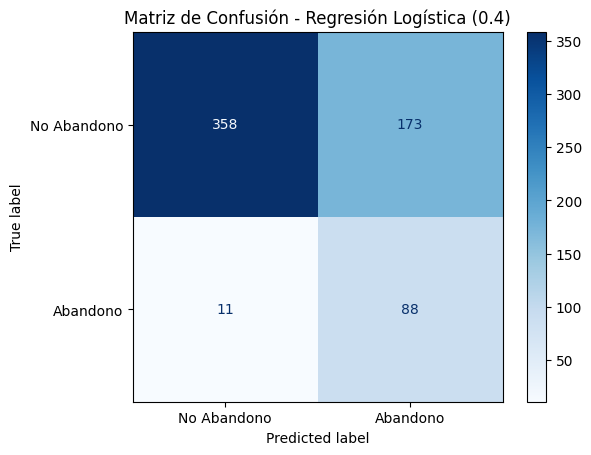

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ajustado, display_labels=['No Abandono', 'Abandono'], cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística (0.4)')
plt.show()

In [13]:
coefs = mejor_modelo.named_steps['log_reg'].coef_[0]
df_importancia = pd.DataFrame({'Variable': columnas_finales, 'Impacto': coefs}).sort_values(by='Impacto', ascending=False)

fig = px.bar(df_importancia, x='Variable', y='Impacto', color='Impacto',
             title='Impacto de Variables en el Abandono (Regresión Logística)',
             color_continuous_scale='RdBu_r')
fig.show()

In [14]:
print("Formulario de Predicción de Abandono")
print("\n" + "="*50)

datos_usuario = {}
campos = [
    ('Fallos_Llamadas', "Número de fallos de llamada: ", int),
    ('Quejas', "El cliente ha presentado quejas (si/no): ", str),
    ('Meses_permanencia', "Meses de antigüedad del cliente: ", int),
    ('Total_llamadas', "Cantidad total de llamadas realizadas: ", int),
    ('Cargo', "Monto del cargo mensual: ", int),
    ('Edad', "Edad del cliente: ", int)
]

for campo, mensaje, tipo in campos:
    while True:
        try:
            valor = input(mensaje)
            if tipo == str:
                if valor.lower() in ['si', 'sí', '1', 'yes', 'y']:
                    datos_usuario[campo] = 1
                elif valor.lower() in ['no', '0', 'n']:
                    datos_usuario[campo] = 0
                else:
                    print("Por favor ingrese 'si' o 'no'")
                    continue
            else:
                datos_usuario[campo] = tipo(valor)
            break
        except ValueError:
            print("Error: Por favor ingrese un valor válido.")

Formulario de Predicción de Abandono

Número de fallos de llamada: 55
El cliente ha presentado quejas (si/no): g
Por favor ingrese 'si' o 'no'
El cliente ha presentado quejas (si/no): si
Meses de antigüedad del cliente: si
Error: Por favor ingrese un valor válido.
Meses de antigüedad del cliente: si
Error: Por favor ingrese un valor válido.
Meses de antigüedad del cliente: si
Error: Por favor ingrese un valor válido.
Meses de antigüedad del cliente: si
Error: Por favor ingrese un valor válido.
Meses de antigüedad del cliente: si
Error: Por favor ingrese un valor válido.
Meses de antigüedad del cliente: si
Error: Por favor ingrese un valor válido.
Meses de antigüedad del cliente: 10
Cantidad total de llamadas realizadas: 55
Monto del cargo mensual: 100
Edad del cliente: 55


In [15]:
df_input = pd.DataFrame([datos_usuario])
# Reordenar columnas para que coincidan con el modelo
df_input = df_input[columnas_finales]

prob_usuario = mejor_modelo.predict_proba(df_input)[:, 1][0]
resultado = "ABANDONO" if prob_usuario >= 0.4 else "NO ABANDONO"

print(f"\n{'='*20}")
print(f"RESULTADO: {resultado}")
print(f"Probabilidad de fuga: {prob_usuario:.2%}")
print(f"{'='*20}")


RESULTADO: NO ABANDONO
Probabilidad de fuga: 0.00%


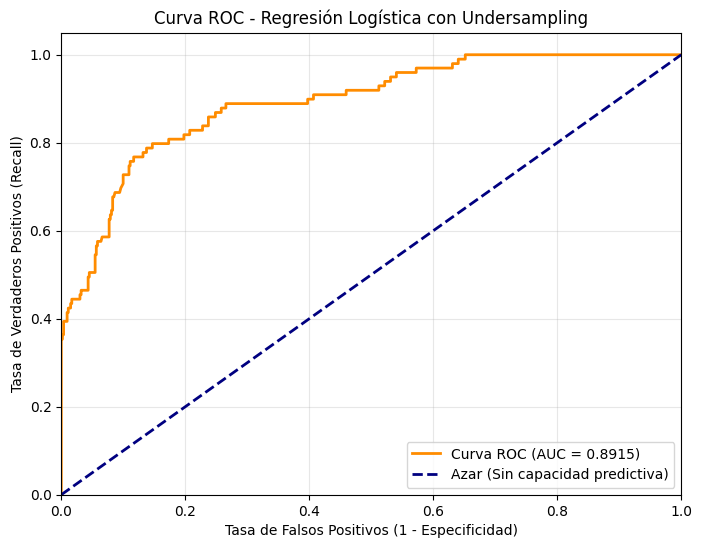

El AUC es: 0.8915


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Calcular las probabilidades (ya lo hicimos, pero lo aseguramos)
probabilidades = mejor_modelo.predict_proba(x_test)[:, 1]

# 2. Calcular la tasa de falsos positivos (fpr) y verdaderos positivos (tpr)
fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
auc_score = roc_auc_score(y_test, probabilidades)

# 3. Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (Sin capacidad predictiva)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Curva ROC - Regresión Logística con Undersampling')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"El AUC es: {auc_score:.4f}")

In [ ]:
import pandas as pd
import pickle

data_for_prediction = {"valor_cliente": 10, "total_mensajes": 4, "total_llamadas": 0}

datos_prueba = pd.DataFrame([data_for_prediction])


with open('mdRegLogiscJoblib.dump', 'rb') as archivo:
    modelo_cargado = pickle.load(archivo)

modelo = modelo_cargado.get('modelo')

columnas_necesarias = modelo_cargado.get('columnas_necesarias', X.columns.tolist())


datos_prueba_aligned = pd.DataFrame(columns=columnas_necesarias)
for col in columnas_necesarias:
    datos_prueba_aligned[col] = datos_prueba[col] if col in datos_prueba.columns else 0 # Default value if missing from input
datos_prueba = datos_prueba_aligned

datos_prueba_scaled = normalización.transform(datos_prueba).copy()

prediccion = modelo.predict(datos_prueba_scaled)

if hasattr(modelo, 'predict_proba'):
    probabilidades = modelo.predict_proba(datos_prueba_scaled)

    probabilidad = probabilidades[0][int(prediccion[0])]
else:
    probabilidad = None


if int(prediccion[0]) == 1:
    prevision = "Va a cancelar"
else:
    prevision = "No va a cancelar"


resultado = {
    "prevision": prevision,
    "probabilidad": round(float(probabilidad), 4)*100 if probabilidad is not None else None,
}

print(resultado)